In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

# 70000 images and each image has 784 features (because 28x28 pixels)

(70000, 784)

In [3]:
y.shape

(70000,)

<function matplotlib.pyplot.show(close=None, block=None)>

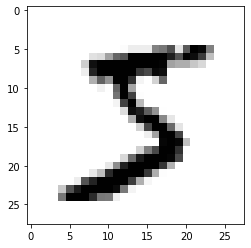

In [4]:
# render one element of the data as an image
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.show

In [5]:
# transform labels into integer data
import numpy as np

y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000]

In [7]:
# Train a binary classifier for the number 5

# create target vectors 
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# Stochastic Gradient Descent (SGD) classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train.values, y_train_5)


SGDClassifier(random_state=42)

In [8]:
sgd_clf.predict([some_digit])

array([ True])

In [9]:
# k-folds cross validation. Split training data into 3 sets (folds). For each fold, train model on the 2 remaining folds 
# and test for accuracy. Will return accuracy > 90 %
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [10]:
# However, even a classifier that always predicts "not 5" will return about 90% accuracy because only about 10% of the
# numbers are 5's. So accuracy is a bad measure of model performance. 

# Instead use a confusion matrix

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

# Confusion Matrix 
# [non-5 predicted correctly, non-5 predicted incorrectly], 
# [5 predicted incorrectly, 5 predicted correctly]
# Each row is an actual class, each column is a predicted class. A perfect classifier would only 
# have non-zero values on the main diagonal



array([[53892,   687],
       [ 1891,  3530]])

In [11]:
from sklearn.metrics import precision_score, recall_score

# Precision = True Positives / (True Positives + False Positives) 
# When a prediction is made, what % is the prediction made
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [12]:
# Recall = True Positives / (True Positives + False Negatives) 
# Out of all the actual positives in the dataset, what % were predicted as such
recall_score(y_train_5, y_train_pred)


0.6511713705958311

In [13]:
# F1 score - harmonic mean of precision and recall. Favors classifiers that have a similar precision and recall. High F1
# means that both precision and recall are high.
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

# Precision/Recall tradeoff - increasing one often means decreasing the other

0.7325171197343846

In [14]:
# Instead of using predict(), get the actual score via the decision_function method. 
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [15]:
# if our decision threshold is 0, this is the same as predict. 
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [16]:
# if our decision threshold is 8000, recall drops
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

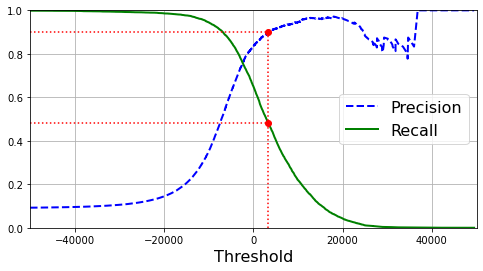

In [17]:
# To investigate how the selected threshold affects precision and recall 

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# use precision_recall_curve to see how precision and recall change across all possible thresholds
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
                                            
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                # Not shown
plt.show()

In [18]:
# Find threshold that gives you 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [19]:
# A classifier with 90% will have low recall
y_train_pred_90 = (y_scores >= threshold_90_precision)

display(precision_score(y_train_5, y_train_pred_90))
display(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293

0.4799852425751706

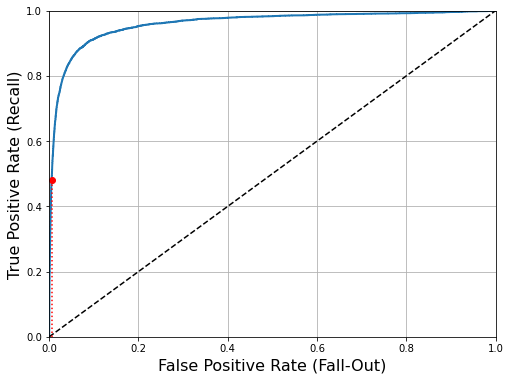

In [23]:
# ROC Curve
# Plots True Positive Rate (recall) vs True Negative Rate
# Random classifier will have ROC curve of a diagonal line and area under the curve will be 0.5
# Perfect classifer will haev a area under the curve of 1

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()